# Modelling fluid inclusion stretching when erupted at the surface (e.g., during slow quenching of a lava flow) 
- This notebook shows how to model the stretching of CO2 dominated fluid inclusions in olivine using python tool pfiFI (DeVitre and Wieser, 2023; EarthArXiv), implemented in DiadFit. Note that this tool is not designed to model FI with fluids other than CO2 at this time, or those in phases other than olivine. It is based on the model of Wanamaker and Evans, 1989.
- In this example (presented in the DiadFit paper), we model the stretching of a 1 micron radius pure CO2 fluid inclusion, 1000 microns away from the crystal rim which was captured at ~30 km and erupted on the surface and slowly quenched for ~1 day. 

## First, make sure CoolProp is installed if using the Span and Wagner 1996 equation of state
- You only need to run this once. If you do not wish to use CoolProp, or face installation problems, please use 'SP94' instead of 'SW96'

In [43]:
%pip install CoolProp

## Next import the necessary packages, including DiadFit

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import DiadFit as pf

## Now let's model stretching and evaluate how density, pressure and radius change over time

### Set your starting and ending pressures in MPa
- Here we will start with an FI that was captured at ~30 km and brought to the surface, so we calculate the pressure in kbar corresponding to this depth with a constant crustal density of 2800 kg/m3 and convert that to MPa
- You can easily calculate the desired pressure using the built-in function 'find_P_for_kmdepth' by inputting a starting depth and a crustal model of your choice
- You can also set them manually. e.g., Pinternal_MPa=900.

In [45]:
Pexternal_MPa=0 # We set the external pressure to 0, as the FI is at the surface

# Next, we calculate the internal pressure of our FI that was captured at ~30km 

target_depth_km = 30 # Choose your desired starting depth in km
crustal_model_config=pf.config_crustalmodel(crust_dens_kgm3=2800) # Configure your desired crustal model. Here we use constant density of 2800 kg/m3. Call help (pf.config_crustalmodel) for more options
tolerance = 0.001  # this defines how close you want to be

# Now estimate pressure
# Note that this function outputs a list, it can be used to estimate pressure for a list of values, not just a single float. 

P_kbar = pf.find_P_for_kmdepth(target_depth_km=target_depth_km, crustal_model_config=crustal_model_config, tolerance=tolerance)

# Now convert this to MPa; this will be our starting internal pressure
Pinternal_MPa=P_kbar[0]*100

print("Calculated Pressure (MPa):", round(Pinternal_MPa))

Calculated Pressure (MPa): 824


### Now, let's set the inclusion and model parameters

In [46]:
T_K = 1200 + 273.15  # Temperature in Kelvin (Here 1200 degrees Celsius converted to Kelvin)

R_m = 1 * 10**-6  # radius of the FI in meters (here 1 micron)
b_m=1000*10**-6 # distance to the crystal edge or crack (here 100 microns)

steps = 100  # Number of steps to iterate
totaltime_s = 86400 # This is the total time you want to remain at the set temperature, in seconds

EOS='SW96' # Equation of state for CO2 (SW96 or SP94) if using SW96, ensure CoolProp is installed
method='RK1' # Numerical method for calculating the radius of the FI (here we use Runge-Kutta 1st order also known as Euler's method)
plotfig=True # Whether to plot the figure or not

### Now run the model
- Note that for this FI, the decrease in density caused by stretching at 1200 C for 1 day is quite significant (~22%) and translates to nearly 40% underestimation on the entrapment pressure!

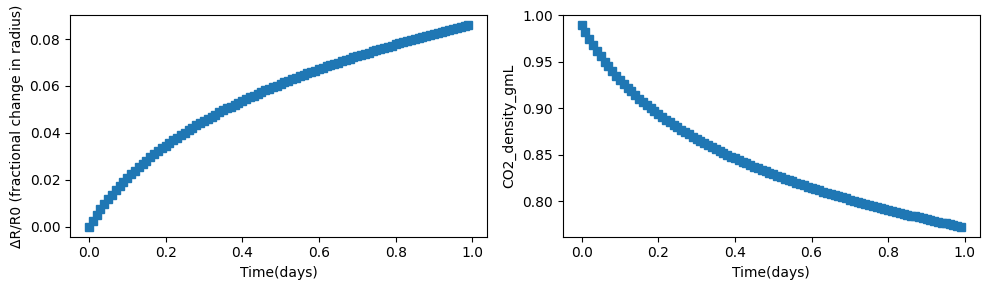

Entrapment Depth (km): 30
Calculated Depth after stretching (km): 17
% Underestimation in Depth (km): 42


,Time(s),Step,dt(s),Pexternal(MPa),Pinternal(MPa),dR/dt(m/s),Fi_radius(μm),b (distance to xtal rim -μm),ΔR/R0 (fractional change in radius),CO2_dens_gcm3,Time(days)
0,0,0,0,0,824.040000,3.024177e-12,1.000000,1000.0,0.000000,0.989807,0.00
1,864,1,864,0,809.087319,3.024177e-12,1.002613,1000.0,0.002613,0.982089,0.01
2,1728,2,864,0,795.385808,2.838709e-12,1.005066,1000.0,0.005066,0.974917,0.02
3,2592,3,864,0,782.757631,2.676017e-12,1.007378,1000.0,0.007378,0.968219,0.03
4,3456,4,864,0,771.059525,2.532062e-12,1.009565,1000.0,0.009565,0.961939,0.04
...,...,...,...,...,...,...,...,...,...,...,...
95,82080,95,864,0,483.289306,4.846096e-13,1.084348,1000.0,0.084348,0.776328,0.95
96,82944,96,864,0,482.155139,4.806777e-13,1.084763,1000.0,0.084763,0.775436,0.96
97,83808,97,864,0,481.033924,4.768136e-13,1.085175,1000.0,0.085175,0.774553,0.97
98,84672,98,864,0,479.925400,4.730154e-13,1.085584,1000.0,0.085584,0.773679,0.98


In [47]:
results = pf.stretch_at_constant_Pext(R_m=R_m, b_m=b_m, T_K=T_K, Pinternal_MPa=Pinternal_MPa, Pexternal_MPa=Pexternal_MPa, 
                                        totaltime_s=totaltime_s, steps=steps, EOS=EOS,method=method,
                                        plotfig=plotfig)

reequilibrated_calculated_depth=pf.convert_pressure_to_depth(P_kbar=results['Pinternal(MPa)'][99]/100,crust_dens_kgm3=2800)[0]
print("Entrapment Depth (km):", round(target_depth_km))
print("Calculated Depth after stretching (km):", round(reequilibrated_calculated_depth))
print("% Underestimation in Depth (km):", round(100*(target_depth_km-reequilibrated_calculated_depth)/target_depth_km))

display(results)
